In [2]:
# Import essential libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut


# Load the merged dataset
merged_path = '/content/merged_processed_data.csv'  # Adjust path if necessary
data = pd.read_csv(merged_path)

# Separate numeric and non-numeric columns
numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()

# Replace inf/-inf with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values in numeric columns with their mean
data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

# Select features and target
features = data.drop(columns=['Growth_Rate(g/2weeks)', 'bi_weekly_period', 'Average_Length(cm)', 'Average_Weight(g)',
  # 'Temperature (C)_RollingMean',
  # 'Temperature (C)_RollingVariance',
  # 'Turbidity (NTU)_RollingMean',
  # 'Turbidity (NTU)_RollingVariance',
  # 'Dissolved Oxygen (g/ml)_RollingMean',
  # 'Dissolved Oxygen (g/ml)_RollingVariance',
  # 'pH_RollingMean',
  # 'pH_RollingVariance',
  # 'Ammonia (g/ml)_RollingMean',
  # 'Ammonia (g/ml)_RollingVariance',
  # 'Nitrate (g/ml)_RollingMean',
  # 'Nitrate (g/ml)_RollingVariance',
  # 'Temperature (C)_Diff',
  # 'Turbidity (NTU)_Diff',
  # 'Dissolved Oxygen (g/ml)_Diff',
  # 'pH_Diff',
  # 'Ammonia (g/ml)_Diff',
  # 'Nitrate (g/ml)_Diff'
                              ])  # Replace target if needed
target = data['Growth_Rate(g/2weeks)']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [3]:
def plot_validation_curve(model, X, y, title="Validation Curve"):
    """
    Plots training and validation errors against the training set size.

    Parameters:
    - model: The pipeline or model to evaluate.
    - X: Feature set.
    - y: Target variable.
    - title: Title of the plot.
    """
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_errors = -train_scores.mean(axis=1)
    valid_errors = -valid_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_errors, label="Training Error", marker='o')
    plt.plot(train_sizes, valid_errors, label="Validation Error", marker='s')
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Squared Error")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


In [4]:
# Pipeline for Linear Regression with scaling
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('model', LinearRegression())
])

# Pipelines for Random Forest and XGBoost
rf_pipeline = Pipeline([
    ('model', RandomForestRegressor(
        random_state=42,
        n_estimators=10,       # Fewer trees
        max_depth=5,           # Shallower trees
        max_features='sqrt'))
])

xgb_pipeline = Pipeline([
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=10,       # Fewer trees
        max_depth=2,           # Shallower trees
        learning_rate=0.5,     # Larger step size
        reg_alpha=0.2,         # L1 regularization
        reg_lambda=2           # L2 regularization
        ))
])


In [5]:
# Train Random Forest
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)

# Train Linear Regression
lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)

# Train XGBoost
xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)

# Evaluate models
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

lr_rmse = mean_squared_error(y_test, lr_preds, squared=False)
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)

print(f"Linear Regression - RMSE: {lr_rmse}, MAE: {lr_mae}, R²: {lr_r2}")
print(f"Random Forest RMSE: {rf_rmse}, R²: {rf_r2}, MAE: {rf_mae}")
print(f"XGBoost RMSE: {xgb_rmse}, R²: {xgb_r2}, MAE: {xgb_mae}")


Linear Regression - RMSE: 1.4993125209634563e-14, MAE: 1.2008172234345693e-14, R²: 1.0
Random Forest RMSE: 0.3908824002769282, R²: 0.9992509239028914, MAE: 0.2627799046658748
XGBoost RMSE: 0.13711760145521174, R²: 0.9999078235195733, MAE: 0.11591142396757113


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [6]:
# Cross-validation for Linear Regression
lr_cv_rmse = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lr_cv_mae = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Cross-validation for Random Forest
rf_cv_rmse = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_cv_mae = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Cross-validation for XGBoost
xgb_cv_rmse = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_cv_mae = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Print cross-validation results
print(f"Linear Regression CV - RMSE: {np.sqrt(-lr_cv_rmse.mean())}, MAE: {-lr_cv_mae.mean()}")
print(f"Random Forest CV - RMSE: {np.sqrt(-rf_cv_rmse.mean())}, MAE: {-rf_cv_mae.mean()}")
print(f"XGBoost CV - RMSE: {np.sqrt(-xgb_cv_rmse.mean())}, MAE: {-xgb_cv_mae.mean()}")

Linear Regression CV - RMSE: 1.4950974085437574e-14, MAE: 1.1282670704148538e-14
Random Forest CV - RMSE: 0.45549598916628814, MAE: 0.2748569934275857
XGBoost CV - RMSE: 0.1858935585727427, MAE: 0.14683865532791426


                                    Feature  Importance
0                           Temperature (C)    0.293937
23                      Nitrate (g/ml)_Diff    0.170113
17           Nitrate (g/ml)_RollingVariance    0.115543
21                                  pH_Diff    0.081948
7           Temperature (C)_RollingVariance    0.061099
18                     Temperature (C)_Diff    0.057792
5                            Nitrate (g/ml)    0.051077
4                            Ammonia (g/ml)    0.045663
15           Ammonia (g/ml)_RollingVariance    0.026265
8               Turbidity (NTU)_RollingMean    0.019169
22                      Ammonia (g/ml)_Diff    0.016773
10      Dissolved Oxygen (g/ml)_RollingMean    0.015485
9           Turbidity (NTU)_RollingVariance    0.012860
6               Temperature (C)_RollingMean    0.009235
12                           pH_RollingMean    0.007169
20             Dissolved Oxygen (g/ml)_Diff    0.005981
1                           Turbidity (NTU)    0

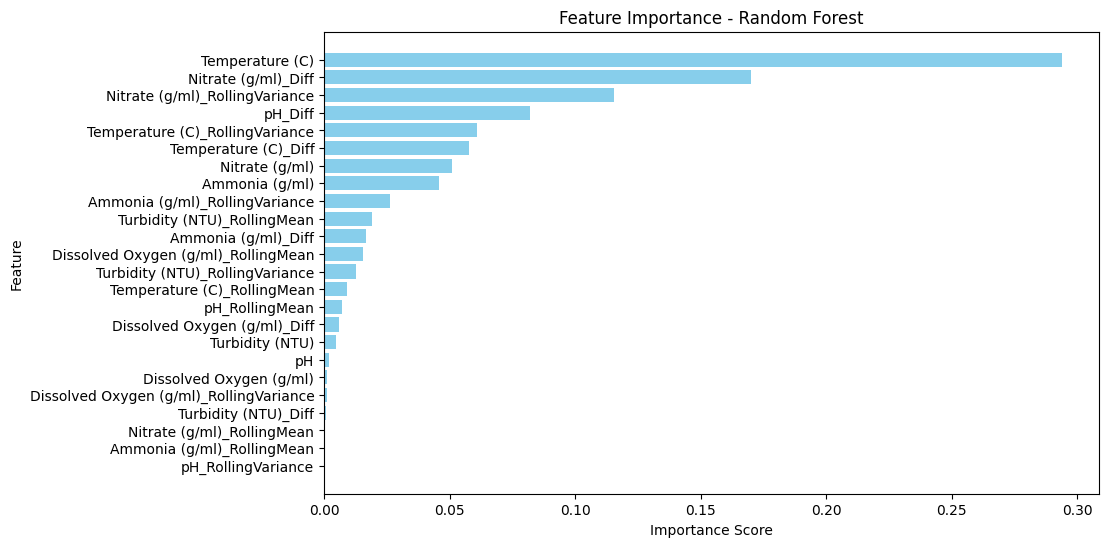

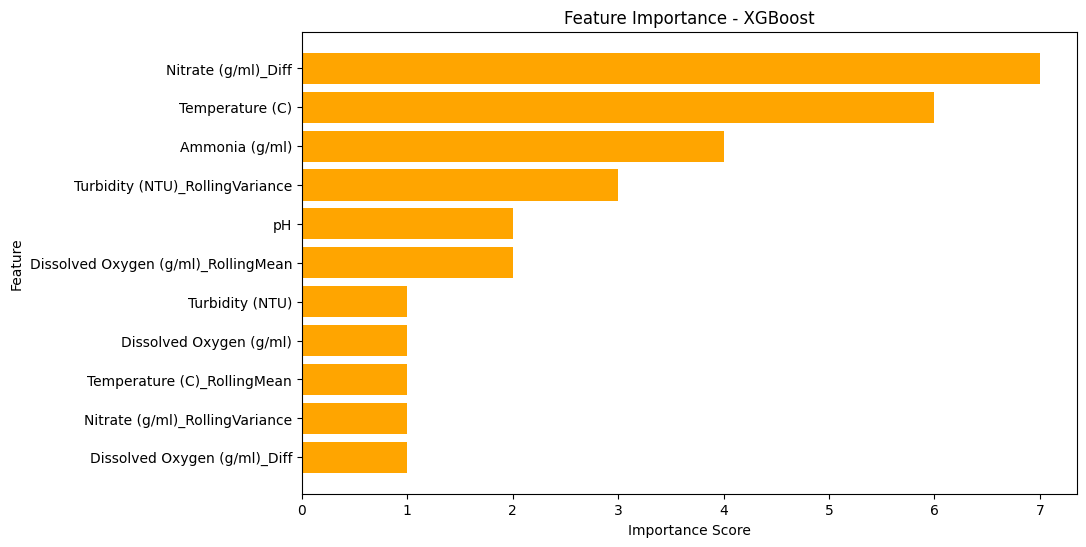

['Temperature (C)',
 'Turbidity (NTU)',
 'Dissolved Oxygen (g/ml)',
 'pH',
 'Ammonia (g/ml)',
 'Nitrate (g/ml)',
 'Temperature (C)_RollingMean',
 'Temperature (C)_RollingVariance',
 'Turbidity (NTU)_RollingMean',
 'Turbidity (NTU)_RollingVariance',
 'Dissolved Oxygen (g/ml)_RollingMean',
 'Dissolved Oxygen (g/ml)_RollingVariance',
 'pH_RollingMean',
 'pH_RollingVariance',
 'Ammonia (g/ml)_RollingMean',
 'Ammonia (g/ml)_RollingVariance',
 'Nitrate (g/ml)_RollingMean',
 'Nitrate (g/ml)_RollingVariance',
 'Temperature (C)_Diff',
 'Turbidity (NTU)_Diff',
 'Dissolved Oxygen (g/ml)_Diff',
 'pH_Diff',
 'Ammonia (g/ml)_Diff',
 'Nitrate (g/ml)_Diff']

In [7]:
# # For Random Forest
# feature_importances = rf_pipeline.named_steps['model'].feature_importances_
# importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})
# print(importance_df.sort_values(by='Importance', ascending=False))

# # For XGBoost
# xgb_pipeline.named_steps['model'].get_booster().feature_names

# For Random Forest
feature_importances = rf_pipeline.named_steps['model'].feature_importances_
importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})
print(importance_df.sort_values(by='Importance', ascending=False))
# Sort feature importance by descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


# Extract feature importance from XGBoost model
xgb_importances = xgb_pipeline.named_steps['model'].get_booster().get_score(importance_type='weight')
xgb_importance_df = pd.DataFrame({
    'Feature': xgb_importances.keys(),
    'Importance': xgb_importances.values()
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], color='orange')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance - XGBoost")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()
xgb_pipeline.named_steps['model'].get_booster().feature_names



In [8]:
# employing LOO for further model validation
loo = LeaveOneOut()

rf_rmse_list = []
xgb_rmse_list = []

for train_index, test_index in loo.split(features):
    X_train_loo, X_test_loo = features.iloc[train_index], features.iloc[test_index]
    y_train_loo, y_test_loo = target.iloc[train_index], target.iloc[test_index]

    # Train Random Forest
    rf_pipeline.fit(X_train_loo, y_train_loo)
    rf_preds = rf_pipeline.predict(X_test_loo)
    rf_rmse_list.append(mean_squared_error(y_test_loo, rf_preds, squared=False))

    # Train XGBoost
    xgb_pipeline.fit(X_train_loo, y_train_loo)
    xgb_preds = xgb_pipeline.predict(X_test_loo)
    xgb_rmse_list.append(mean_squared_error(y_test_loo, xgb_preds, squared=False))

# Summary statistics
print(f"Random Forest LOO-CV RMSE: Mean={np.mean(rf_rmse_list)}, Std Dev={np.std(rf_rmse_list)}")
print(f"XGBoost LOO-CV RMSE: Mean={np.mean(xgb_rmse_list)}, Std Dev={np.std(xgb_rmse_list)}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

Random Forest LOO-CV RMSE: Mean=0.12458777098807401, Std Dev=0.15955935485267164
XGBoost LOO-CV RMSE: Mean=0.12022248206020368, Std Dev=0.08472625632598046


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

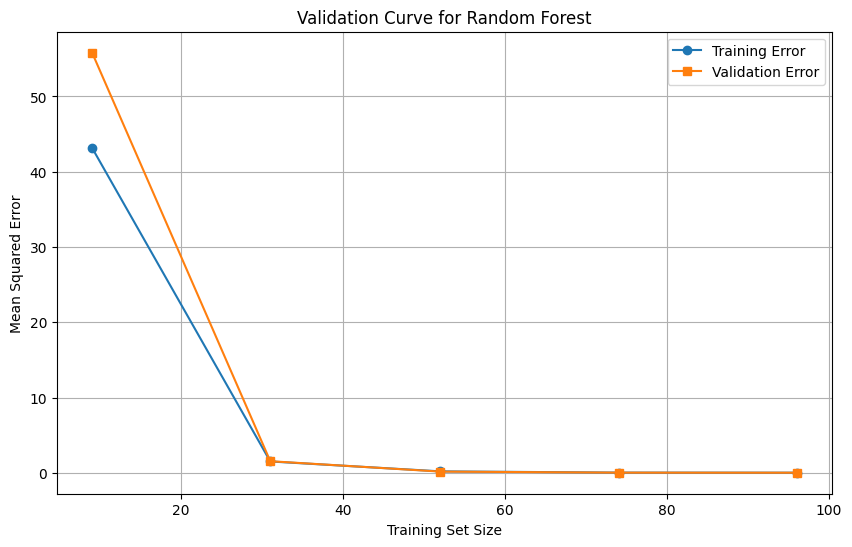

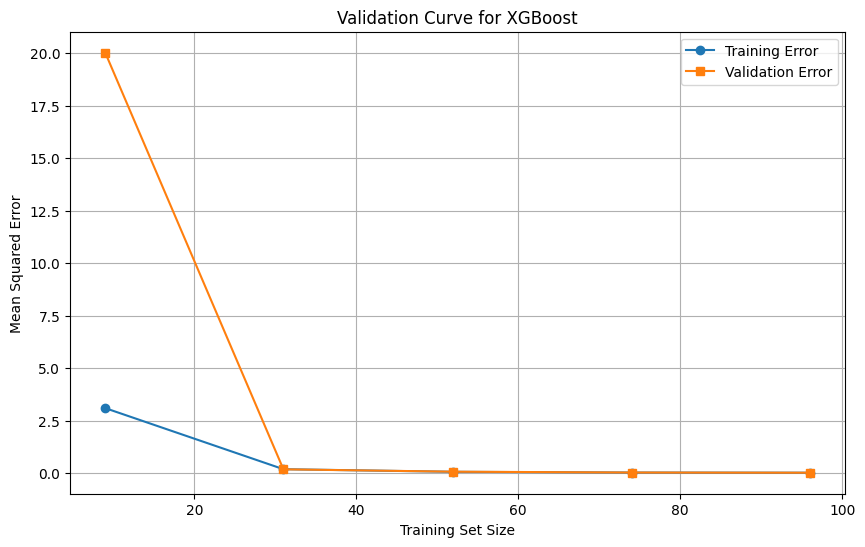

In [9]:
# Random Forest Validation Curve
plot_validation_curve(rf_pipeline, features, target, title="Validation Curve for Random Forest")

# XGBoost Validation Curve
plot_validation_curve(xgb_pipeline, features, target, title="Validation Curve for XGBoost")


In [10]:
# Store metrics in a dictionary
metrics = {
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [lr_rmse, rf_rmse, xgb_rmse],
    "MAE": [lr_mae, rf_mae, xgb_mae],
    "R²": [lr_r2, rf_r2, xgb_r2]
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)

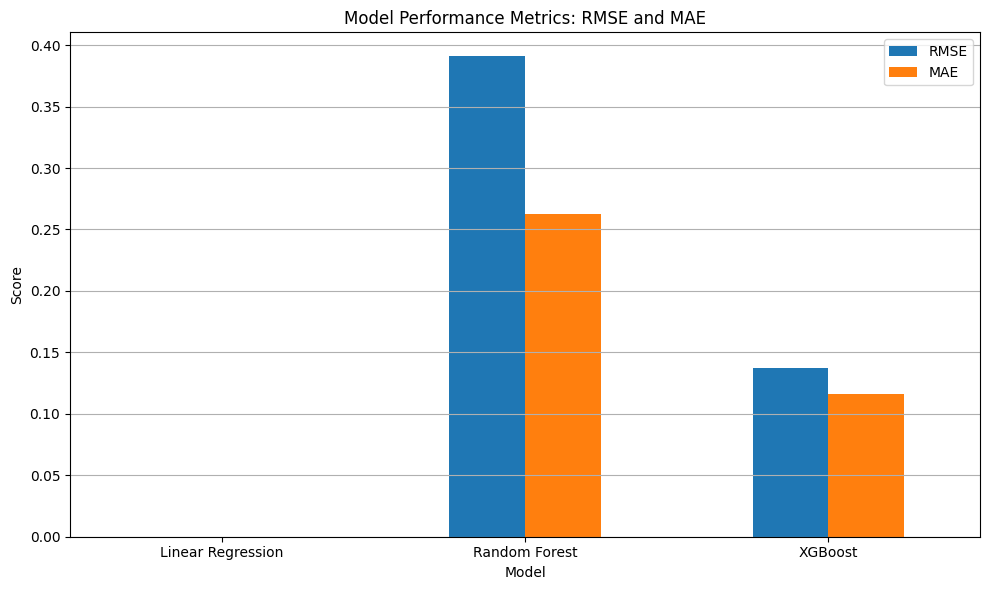

In [11]:
# Plot RMSE and MAE
metrics_df.plot(x="Model", y=["RMSE", "MAE"], kind="bar", figsize=(10, 6))
plt.title("Model Performance Metrics: RMSE and MAE")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.legend(["RMSE", "MAE"], loc="upper right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

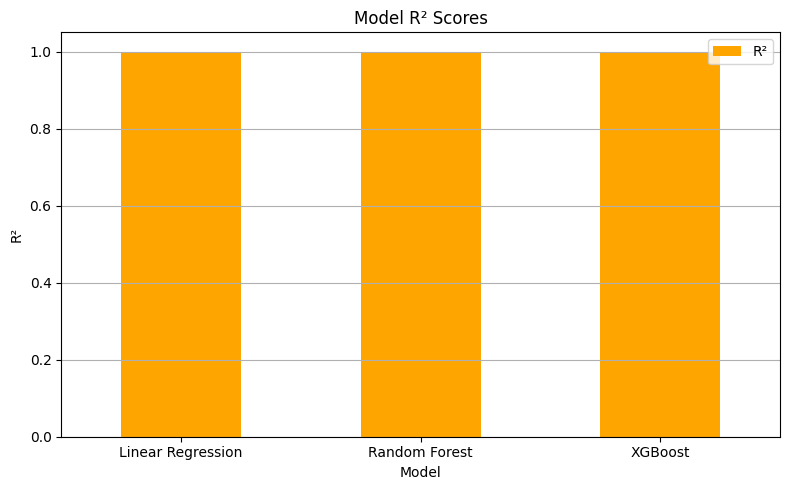

In [12]:
# Plot R²
metrics_df.plot(x="Model", y="R²", kind="bar", color="orange", figsize=(8, 5))
plt.title("Model R² Scores")
plt.ylabel("R²")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [13]:
# Save as CSV
metrics_df.to_csv("model_comparative_analysis.csv", index=False)
metrics_df.head(5)

,Model,RMSE,MAE,R²
0,Linear Regression,1.499313e-14,1.200817e-14,1.000000
1,Random Forest,3.908824e-01,2.627799e-01,0.999251
2,XGBoost,1.371176e-01,1.159114e-01,0.999908
